# Static Mapping

This notebook demonstrates how to use the dynamic mapping framework *EvoMap*. For the methodological background and a detailed description, see our paper [[1]](#ref_1). 

This tutorial covers data preparation, how to run the model, how to evaluate its results, tuning its hyperparameter and several useful functions provided as part of this package (e.g., for creating market maps based on its output).  

For a more condensed overview on how to run *EvoMap* for your own data, see the notebook ***Quickstart.ipynb***. 

## Tutorial Sections

1. [Data Preparation](#section_1)

2. [Running the Model](#section_2)

3. [Exploring Model Output](#section_3)

4. [Evaluating Model Output](#section_4)

5. [Hyperparameter Tuning](#section_5)

6. [Chosing a Different Mapping Method](#section_6)

7. [Special Cases and Extensions](#section_7)


## Background:


**Author:** Maximlian Matthe (matthe@wiwi.uni-frankfurt.de)

**Last updated:** April 2022

*If you use this package or parts of its code, please cite our work*

**References**

<a id = "ref_1">[1]</a> Matthe, M., Ringel, D. M., Skiera, B. (2022), "Mapping Market Structure Evolution", Working Paper.

<a id = "ref_2">[2]</a> Matthe, M. (2022), "marketmaps: A Python Package for Analyzing Markets in Maps", Working Paper.



<a id = 'section_1'></a>
## Data Preparation
First, lead all required imports for this demonstration and set the seed to ensure reproducibility. 

In [1]:
import pandas as pd
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(123) 

For this demonstration, we use a sample of the TNIC data also used in [[1]](#ref_1). The original data is provided at https://hobergphillips.tuck.dartmouth.edu/. The data consists of an edgelist, that is, firm-firm relationships. 

We merge this edgelist with further firm information. The merged data includes the following variables: 

| Variable | Description | Source |
| --- | --- | --- |
| year | Fiscal year | TNIC |
| gvkey | Firm identifier | TNIC |
| score | Similarity score | TNIC |
| name | Firm name | Compustat |
| mkvalt | Market value | Compustat |
| sic | SIC Code | Compustat |

In the final data, each row corresponds to a single firm-firm pair at a specific point in time. Thus, each firm variable appears twice in each row (once for each firm). We provide the merged data on our website, from which you can directly and store it. 

In [2]:
if not os.path.exists("data"):
    os.mkdir("data")
    
if not os.path.exists("data/tnic_sample_merged.csv"):
    df_tnic = pd.read_csv("http://evomap.io/TNIC/tnic_sample/tnic_sample_merged.csv")
    df_tnic.to_csv(r'data/tnic_sample_merged.csv', index = None)
else:
    df_tnic = pd.read_csv(r"data/tnic_sample_merged.csv")

This sample includes more than 1,000 different firms. To simplify our demonstration (and accelerate the runtime of this notebook), we pick a smaller sub-sample from these data. Specifically, we pick the 250 biggest firms (by market value). We then drop those with less than 5 peer firms in any period. You should always make sure that your data includes enough non-zero relationships, as otherwise mapping methods (such as t-SNE) cannot faithfully embed these firms into lower dimensional (e.g., 2D) space. 

In [3]:
sample_firms = df_tnic.sort_values('mkvalt1', ascending = False).name1.unique()[:25]
sample_firms_competitors = np.array([])
for firm in sample_firms:
    comps = df_tnic.query('name1 == @firm').query('year == 1998').sort_values('score', ascending = True).name2.values[:20]
    sample_firms_competitors = np.unique(np.concatenate((sample_firms_competitors, comps)))
    
sample_firms = np.unique(np.concatenate((sample_firms, sample_firms_competitors)))
df_sample = df_tnic.query('name1 in @sample_firms').query('name2 in @sample_firms')

print("Number of firms before pruning: {0}".format(len(sample_firms)))

def get_min_num_neighbors(df):
    """ Get the minimum number of neighbors within the TNIC edgelist across all firms and years. """
    min_neighbors_i = df.groupby(['name1', 'year']).agg({'name2':'nunique'}).groupby('name1').agg('min').min().values
    min_neighbors_j = df.groupby(['name2', 'year']).agg({'name1':'nunique'}).groupby('name2').agg('min').min().values
    return np.minimum(min_neighbors_i, min_neighbors_j)

def get_num_years(df, name):
    return len(df.query('name1 == @name').year.unique())

while get_min_num_neighbors(df_sample) < 3:
    print("Pruning the network..")
    sample_firms = df_sample.groupby(['name1', 'year']).agg({'name2': 'nunique'}).groupby('name1').agg('min').query('name2 >= 3').index.values
    df_sample = df_sample.query('name1 in @sample_firms').query('name2 in @sample_firms')
    sample_firms = [firm for firm in sample_firms if get_num_years(df_sample, firm) == 20]
    df_sample = df_sample.query('name1 in @sample_firms').query('name2 in @sample_firms')
    
display("Final sample size: {0}".format(df_sample.name1.nunique()))

Number of firms before pruning: 376
Pruning the network..
Pruning the network..
Pruning the network..
Pruning the network..


'Final sample size: 275'

The final sample includes:  

In [4]:
display("{0} firms and {1} years".format(df_sample.name1.nunique(), df_sample.year.nunique()))

'275 firms and 20 years'

Finally, we need to turn this edgelist into relationship matrices. Specifically, the expected input for *EvoMap* is a list of numpy arrays, each containing all pairwise relationships at a specific point in time. 

**Important note:** Make sure that each matrix has the same size and that its rows & columns are ordered consistently! If you do not observe certain firms at some points in time (e.g., due to entry or exit), you should provide inclusion vectors (covered [later](#inclusions)).

This package provides some helpful functions for such transformations (see *transformations.py*). 

In [5]:
from evomap.transformations import edgelist2matrix, sim2dist

def build_distance_matrices(df):
    """Turn tnic data from time-indexed edgelist format to a sequence of square distance matrices. """
    years = df['year'].sort_values().unique()
    D_ts = []
    for year in years:
        display("Building matrix for year {0}".format(year))
        S_t, names = edgelist2matrix(
            df = df,
            score_var = 'score',
            id_var_i = 'name1',
            id_var_j = 'name2',
            time_var = 'year',
            time_selected = year)
        D_t = sim2dist(S_t)
        D_ts.append(D_t)
                
    return D_ts, names, years

D_ts, names, years = build_distance_matrices(df_sample)
n_samples = D_ts[0].shape[0]
n_periods = len(D_ts)

'Building matrix for year 1998'

'Building matrix for year 1999'

'Building matrix for year 2000'

'Building matrix for year 2001'

'Building matrix for year 2002'

'Building matrix for year 2003'

'Building matrix for year 2004'

'Building matrix for year 2005'

'Building matrix for year 2006'

'Building matrix for year 2007'

'Building matrix for year 2008'

'Building matrix for year 2009'

'Building matrix for year 2010'

'Building matrix for year 2011'

'Building matrix for year 2012'

'Building matrix for year 2013'

'Building matrix for year 2014'

'Building matrix for year 2015'

'Building matrix for year 2016'

'Building matrix for year 2017'

<a id = 'section_2'></a>
## Running the Model

First, fix a random starting initialization. While doing so is not strictly necessary, it is good practice - especially when one wants to compare the derived maps to solutions by other approaches. 

In [6]:
Y_init = np.random.normal(0.0,1.0,size=(n_samples,2))
Y_init_ts = [Y_init]*n_periods

Then, choose a value for the hyperparamter alpha and run the model. We will cover ways how to identify appropriate values for EvoMap's hyperparameters [later](#section_5)

In [7]:
from evomap.EvoTSNE import EvoTSNE

EvoMap = EvoTSNE(
    init = Y_init_ts,
    alpha = 0.001)

Y_ts = EvoMap.fit_transform(D_ts)

The output is a list of map coordinates, each stored in a ndarray of shape (n_samples, d), where d is typically = 2. 

This package provides multiple tools to explore these results. Here, we look at the first 4 maps as a sequence. We cover more advanced alternatives for exploration in [Section 3: Exploring Model Output](#section_3).

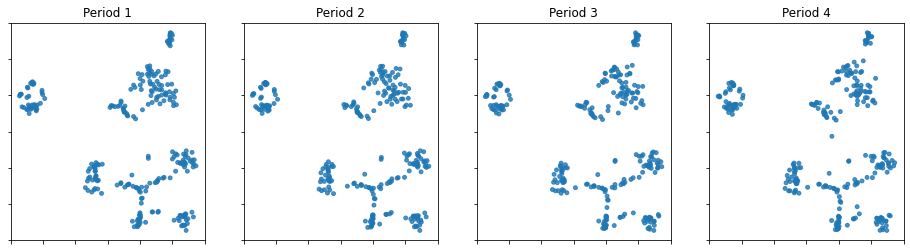

In [8]:
from evomap.printer import draw_map_sequence

draw_map_sequence(Y_ts[:4])

<a id = 'section_3'></a>
## Exploring Model Output

This package provides three ways to explore EvoMap's output: 

1. [Draw a static map](#static_map)
2. [Draw a sequence of static maps](#sequence)
3. [Draw a dynamic map](#dynamic_map) (i.e., an overlay of subsequent maps)

All necessary functions are included in the "printer" module and provide lots of flexibility to adjust their aesthetics.

<a id = 'static_map'></a>
### Draw a Static Map

To draw a single static map, simply use the corresponding function ```draw_map()```.

<AxesSubplot:>

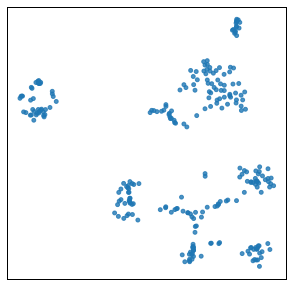

In [9]:
from evomap.printer import draw_map

draw_map(Y_ts[0])

Aesthetics of the map can easily be adjusted via additional arguments. For instance, if class labels are available (e.g., obtained via clustering or additional metadata), they can be added as colors. Here, we can use SIC codes for coloring:

<AxesSubplot:>

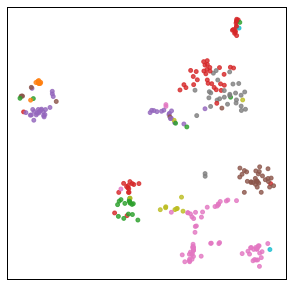

In [10]:
sic_codes = pd.DataFrame({'name1' : names}).merge(df_sample[['name1', 'sic1']], on = 'name1', how = 'left').drop_duplicates('name1')['sic1'].map(lambda x: str(x)[:1]).values
draw_map(Y_ts[0], c = sic_codes)


One can further annotate the map, using clusters

C:\Users\MPMATTHE\Anaconda3\envs\evomap-replication-env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  """Entry point for launching an IPython kernel.
C:\Users\MPMATTHE\Anaconda3\envs\evomap-replication-env\lib\site-packages\numpy\core\fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


<AxesSubplot:>

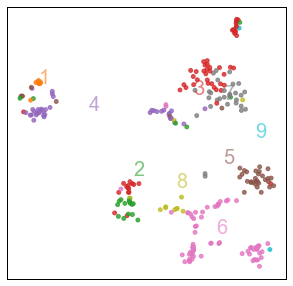

In [11]:
draw_map(Y_ts[0], c = sic_codes, annotate = 'clusters')

or labels. Note that one can also use additional keyword arguments to adjust the plot and its labels further. 

<AxesSubplot:>

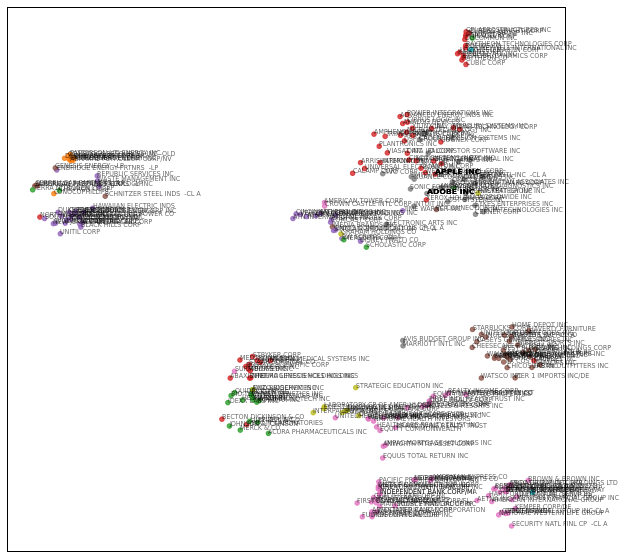

In [12]:
draw_map(
    Y_ts[0], 
    c = sic_codes, 
    annotate = 'labels', 
    labels = names, 
    highlight_labels = ['APPLE INC', 'ADOBE INC'],
    fig_size = (10,10),
    fontdict = {'size': 8},
    scatter_kws = {'s' : 20})